In [2]:
import numpy as np

# Image

In [14]:
size = 1
MAX_VALUE = 255
MIN_VALUE = 0
IMAGE_SIZE_X = 50
IMAGE_SIZE_Y = 50
xCenter = IMAGE_SIZE_X/2
yCenter = IMAGE_SIZE_Y/2
l = 1

#I = np.ceil((MAX_VALUE - MIN_VALUE) * np.random.rand(size) + MIN_VALUE)
#Cx = np.ceil((IMAGE_SIZE_X)/2 + SIGMA*np.random.randn(size)).astype('int')
#Cx = np.clip(Cx,0,IMAGE_SIZE_X)
#Cy = np.ceil((IMAGE_SIZE_Y)/2 +  SIGMA*np.random.randn(size)).astype('int')
#Cy = np.clip(Cy,0,IMAGE_SIZE_Y)

I = np.array([180, 100, 100, 130])
Cx = np.array([4, 8, 5, 2])
Cy = np.array([2, -3, -8, -4])

minI = np.min(I)
argminI = np.argmin(I)
maxI = np.max(I)
argmaxI = np.argmax(I)

print('min I: %s at (%s,%s)\n' \
      'max I: %s at (%s,%s)\n' % (minI, Cx[argminI], Cy[argminI],
                                  maxI, Cx[argmaxI], Cy[argmaxI]))

min I: 100 at (8,-3)
max I: 180 at (4,2)



In [15]:
# Basis function in pixel domain
def psi(x, y, l, Cx, Cy):
    return (1.0 / (np.sqrt(2.0 * np.pi) * l)) * np.exp(-(1.0 / 2) * ((x - Cx) * (x - Cx) + (y - Cy) * (y - Cy)) / (l * l))

In [16]:
G_SIZE_REAL =  500
x = np.linspace(0,IMAGE_SIZE_X,G_SIZE_REAL) - xCenter
y = np.linspace(0,IMAGE_SIZE_Y,G_SIZE_REAL) - yCenter
G = np.zeros([G_SIZE_REAL, G_SIZE_REAL])

N_BASIS = I.shape[0]

for i in range(G_SIZE_REAL):
    for j in range(G_SIZE_REAL):
        for k in range(N_BASIS):
            G[i,j] += I[k]*psi(x[i],y[j],l,Cx[k],Cy[k])
        
G_fft = np.fft.fft2(G)
G_fft = np.fft.fftshift(G_fft)

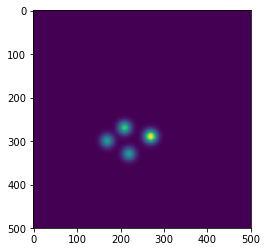

In [17]:
import matplotlib.pyplot as plt

plt.imshow(G)
plt.show()

# Model

In [18]:
import theano.tensor as tt
import numpy as np

# basis function
def phi(u, v, l, Cx, Cy):
    return np.exp(-2*np.pi**2*(u*u+v*v)*l**2)*np.exp(2*np.pi*1j*(Cx*u+Cy*v))

def V_obs(u, v, alpha, l, Cx, Cy, IMAGE_SIZE_X = 50, IMAGE_SIZE_Y = 50):
    
    u_aux = u - IMAGE_SIZE_X/2
    v_aux = v - IMAGE_SIZE_Y/2
    
#     print(u_aux)
    
    A_u = tt.exp(-2*np.pi**2*(u_aux*u_aux)*l**2)
    A_v = tt.exp(-2*np.pi**2*(v_aux*v_aux)*l**2)
    A   = tt.outer(A_u,A_v)
    print(A.eval().shape)
#     print(A.shape)
    
    imagExp_u = tt.exp(2*np.pi*1j*(Cx[:,np.newaxis]*u_aux))
    imagExp_v = tt.exp(2*np.pi*1j*(Cy[:,np.newaxis]*v_aux))
    print(imagExp_u.eval().shape)
#     print(imagExp_u.shape)
    imagExp   = imagExp_u.dimshuffle(0, 1, 'x') * imagExp_v.dimshuffle(0, 'x', 1)
    print(imagExp.eval().shape)
    
#     print((alpha*A*imagExp).eval().shape)
    out = tt.sum(alpha*A*imagExp, axis = 0)
    
#     print(imagExp.shape)

#     print(cosPart.shape, sinPart.shape)    
    return tt.real(out), tt.imag(out)

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [19]:
# alpha = np.array([1,1])
# V_obs_real, V_obs_imag = V_obs(x+25,y+25, alpha, l,Cx, Cy)
# print(np.max(V_obs_imag.eval()))

# u_ej = np.array([[1,1,1,1,1,1],[0.5,0.5,0.5,0.5,0.5,0.5]])
# B_ej = 2*np.array([[1,1,1,1,1,1]])
# print(u_ej)
# print(B_ej)
# print(B_ej[:,np.newaxis]*u_ej)

# a = np.arange(10).reshape(2,5)
# a_tt = theano.shared(a)
# print(a)
# b = 0.5*np.arange(10.).reshape(2,5)
# b_tt = theano.shared(b)
# print(b)
# print('----------')
# c = np.tensordot(a,b, axes=(1,1))
# print(c)

import theano
a = theano.shared(np.asarray([[1,1,1],[2,2,2],[3,3,3],[4,4,4]]))
b = theano.shared(np.asarray([13,13,13]))
print(a.eval().shape)
print(b.eval().shape)

print(tt.sum((a*b), axis=0).eval())

(4, 3)
(3,)
[130 130 130]


In [20]:
G_SIZE_MODEL =  G_SIZE_REAL

factor = (IMAGE_SIZE_X*IMAGE_SIZE_Y/G_SIZE_MODEL)
#factor = 1

G_fft_model = np.zeros((G_SIZE_MODEL,G_SIZE_MODEL),dtype=np.complex128)

u = np.linspace(0,IMAGE_SIZE_X,G_SIZE_MODEL) - xCenter
u = u/factor
v = np.linspace(0,IMAGE_SIZE_Y,G_SIZE_MODEL) - yCenter
v = v/factor

for i in range(G_SIZE_MODEL):
    for j in range(G_SIZE_MODEL):
        for k in range(N_BASIS):
            G_fft_model[i,j] += I[k]*l*np.sqrt(np.pi/2)*phi(u[i],v[j],l,Cx[k],Cy[k])

** Definir una función, graficar ambas y calcular la anti transformada numérica. Para entender como funciona la FFT de numpy. **

*Probar con cosine y exponential.*

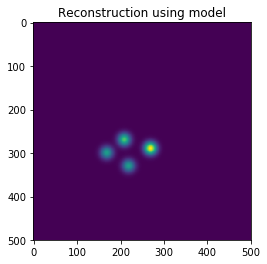

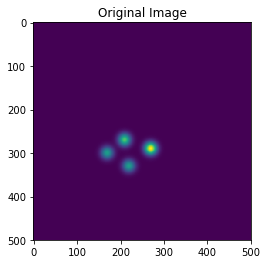

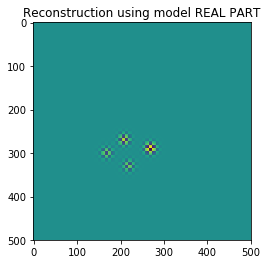

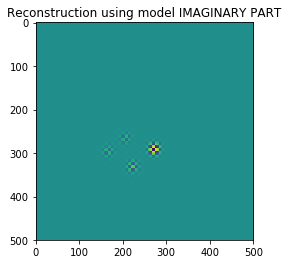

In [22]:
from scipy import ndimage

G_model = np.fft.ifft2(G_fft_model)
G_model = np.fft.fftshift(G_model)
G_model.real = ndimage.rotate(G_model.real, 90*2)
G_model.imag = ndimage.rotate(G_model.imag, 90*2)
plt.imshow(np.abs(G_model))
plt.title('Reconstruction using model')
plt.show()

plt.imshow(G)
plt.title('Original Image')
plt.show()


plt.imshow(G_model.real)
plt.title('Reconstruction using model REAL PART')
plt.show()

plt.imshow(G_model.imag)
plt.title('Reconstruction using model IMAGINARY PART')
plt.show()

In [ ]:
xIndex = np.ceil( np.argmax(np.max(np.abs(G_model), axis = 0)) ).astype(int)
yIndex = np.ceil( np.argmax(np.max(np.abs(G_model), axis = 1)) ).astype(int)
xIndexOr = np.ceil( np.argmax(np.max(G, axis = 0)) ).astype(int)
yIndexOr = np.ceil( np.argmax(np.max(G, axis = 1)) ).astype(int)

print('-------------------------------------------------------------------')
print('Reconstruction (x index, y index, Max Value): (%i, %i, %f)' % (xIndex, yIndex, np.max(np.abs(G_model)) ) )
print('      Original (x index, y index, Max Value): (%i, %i, %f)' % (xIndexOr, yIndexOr, np.max(G) ) )
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('Reconstruction Centers: (%f, %f)' % (u[xIndex]*factor, u[yIndex]*factor))
print('      Original Centers: (%f, %f)' % (x[xIndexOr], y[yIndexOr]) )
print('-------------------------------------------------------------------')

In [ ]:
coef = np.max(G)/np.max(np.abs(G_model))
dx = x[1]-x[0]
du = u[1]-u[0]
print(coef)
print(dx)
print(du)
print(dx/du)
print(dx**2*coef)